# Part A: Transfer Learning

Author: _Thirada Tiamklang_

In Part A, your task is to analyse the architectural difference between 3 CNN models and perform transfer learning on them to accurately predict 101 different classes from the Food101 Dataset.

## 1. Loading and Exploration of the Dataset

In [138]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [139]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

We will use the image size of 299x299 pixels for GoogLeNet

In [140]:
image_size = 299  
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images while maintaining aspect ratio
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [141]:
# Define the root directory where the Food101 dataset images are located
data_dir = '/Users/thiradatiamklang/Desktop/DL/AT2/food-101/images'
# Create the full dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

## 2. Preparing the Dataset

We will sample the data for 6 percent out of the whole images

In [142]:
sample_size = 0.06
data_size = len(full_dataset)
indices = list(range(data_size))
sample_indices = torch.randperm(data_size)[:int(sample_size*data_size)]

In [143]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [144]:
# Split indices into training and combined validation/test indices
train_indices, test_val_indices = train_test_split(range(len(sample_indices)), test_size=(val_ratio + test_ratio), random_state=42)

# Split combined validation/test indices into separate validation and test indices
val_indices, test_indices = train_test_split(test_val_indices, test_size=test_ratio/(val_ratio + test_ratio), random_state=42)

train_set = Subset(full_dataset, train_indices)  # Subset for training data
val_set = Subset(full_dataset, val_indices)      # Subset for validation data
test_set = Subset(full_dataset, test_indices)    # Subset for test data

We will call dataloader based on batche size

In [145]:
# Define the batch size
batch_size = 20  
# Create DataLoader instances for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [146]:
# Print sizes of datasets
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Training set size: 4242
Validation set size: 909
Test set size: 909


In [147]:
# Get the class labels
class_labels = full_dataset.classes
# Print the class labels
print("Class labels:", class_labels)
print(f"Total number of classes: {len(class_labels)}")

Class labels: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaro

__Note:__ The number of classes is 101 from food-101

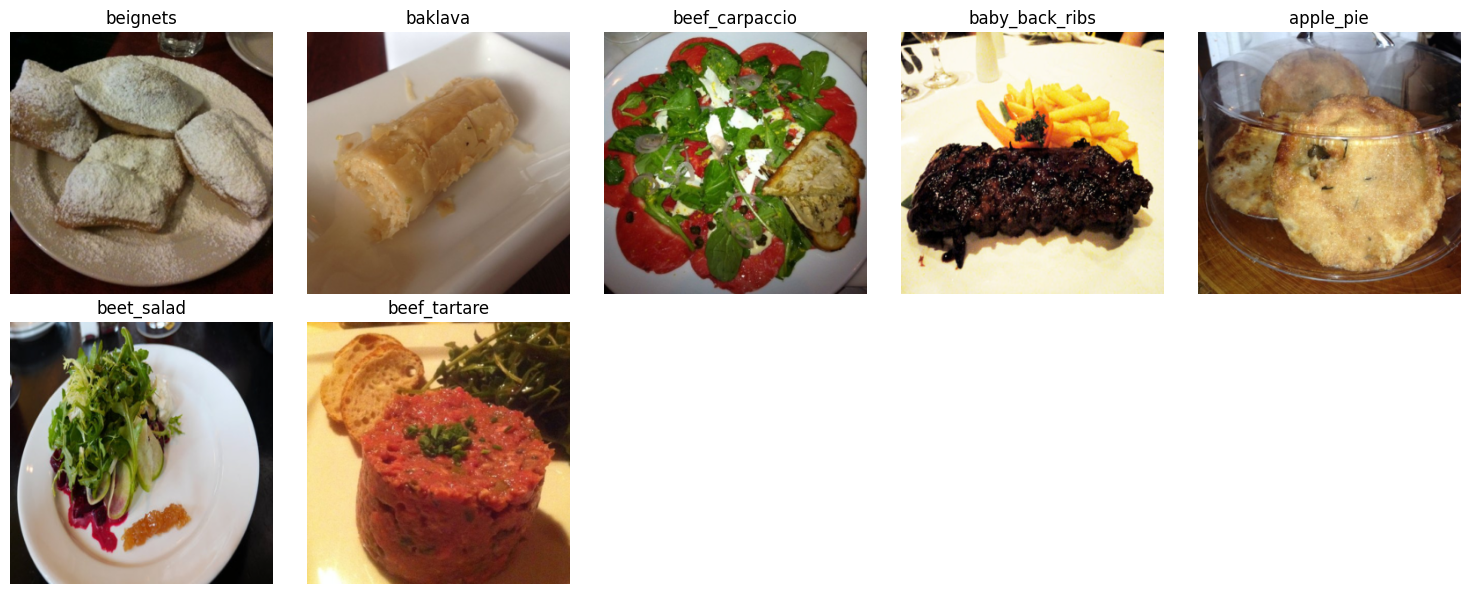

In [148]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import numpy as np  # Import NumPy for numerical operations

# Define a function to display images with labels
def show_images(images, labels, class_labels):
    # Calculate the number of images and rows required
    num_images = len(images)
    num_rows = (num_images + 4) // 5  # 5 images per row, rounded up
    # Create a figure and axes for subplots
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, 3 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop through the images and corresponding labels
    for i, (image, label) in enumerate(zip(images, labels)):

        image = image.numpy().transpose((1, 2, 0))  # Convert from tensor to NumPy array and change the channel dimension
        mean = np.array([0.485, 0.456, 0.406])  # Mean values used for normalization
        std = np.array([0.229, 0.224, 0.225])  # Standard deviation values used for normalization
        image = std * image + mean  # Denormalize the image
        image = np.clip(image, 0, 1)  # Clip pixel values to range [0, 1]

        # Display the image and set its title as the class label
        axes[i].imshow(image)  # Display the image
        axes[i].set_title(class_labels[label])  # Set the title of the subplot as the class label
        axes[i].axis('off')  # Hide axis

    # Hide empty subplots
    for j in range(num_images, num_rows * 5):
        axes[j].axis('off')  # Hide axis for empty subplots

    # Adjust layout and display the plot
    plt.tight_layout()  # Adjust the layout of subplots
    plt.show()  # Display the plot

# Get one image from each class
images, labels = [], []  # Initialize lists to store images and labels
classes_found = set()  # Keep track of classes already found
for img, lbl in train_loader:  # Iterate through the training loader
    for image, label in zip(img, lbl):  # Iterate through each image and label in the batch
        # Check if we have already found an image from this class
        if class_labels[label.item()] not in classes_found:
            images.append(image)  # Add the image to the list of images
            labels.append(label)  # Add the label to the list of labels
            classes_found.add(class_labels[label.item()])  # Add the class to the set of found classes
    # If we have found one image from each class, stop looping
    if len(images) == len(class_labels):
        break

# Display one image from each class with 5 images per row
show_images(images, labels, class_labels)  # Call the show_images function to display the images

## 3. Transfer Learning

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.1 GoogleNet

__[1.] CNN Model Architecture__

We will replace the model head with Global average layer and 3 fully connected layers.

In [150]:
# Load the pre-trained models
googlenet = models.googlenet(pretrained=True)
# Freeze pre-trained layers
for param in googlenet.parameters():
    param.requires_grad = False
# Get the number of input features for the fully connected layer
num_ftrs = googlenet.fc.in_features
num_classes = 101

googlenet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),  # First fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),       # Second fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)  # Final fully connected layer for predictions
        )
google_tuned_model = googlenet
# Print the tuned GoogLeNet model
print(google_tuned_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [151]:
criterion = nn.CrossEntropyLoss()
optimizer_google = optim.Adam(google_tuned_model.parameters(), lr=0.00001)

In [167]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

In [153]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer_google)
google_tuned_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

__[2.] Train and Evaluation of Model__

In [154]:
lr_scheduler = ReduceLROnPlateau(optimizer_google, mode='min', factor=0.1, patience=3, min_lr=1e-6)
custom_callback.set_model(google_tuned_model)

In [155]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    google_tuned_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer_google.zero_grad()  # Zero the parameter gradients
        outputs = google_tuned_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer_google.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    google_tuned_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = google_tuned_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 3.9824, Train Accuracy: 0.1702, Val Loss: 2.9510, Val Accuracy: 0.2596
Epoch [2/10], Train Loss: 2.1893, Train Accuracy: 0.2324, Val Loss: 1.8949, Val Accuracy: 0.3223
Epoch [3/10], Train Loss: 1.8242, Train Accuracy: 0.3454, Val Loss: 1.7855, Val Accuracy: 0.5039
Epoch [4/10], Train Loss: 1.7491, Train Accuracy: 0.4488, Val Loss: 1.7183, Val Accuracy: 0.4884
Epoch [5/10], Train Loss: 1.6885, Train Accuracy: 0.5123, Val Loss: 1.6584, Val Accuracy: 0.5281
Epoch [6/10], Train Loss: 1.6232, Train Accuracy: 0.5514, Val Loss: 1.5834, Val Accuracy: 0.5930
Epoch [7/10], Train Loss: 1.5503, Train Accuracy: 0.6033, Val Loss: 1.5052, Val Accuracy: 0.6271
Epoch [8/10], Train Loss: 1.4839, Train Accuracy: 0.6129, Val Loss: 1.4488, Val Accuracy: 0.6304
Epoch [9/10], Train Loss: 1.4239, Train Accuracy: 0.6287, Val Loss: 1.3745, Val Accuracy: 0.6623
Epoch [10/10], Train Loss: 1.3622, Train Accuracy: 0.6355, Val Loss: 1.3233, Val Accuracy: 0.6689


In [156]:
# Evaluation for test data
google_tuned_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of sjamples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs =  google_tuned_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 1.3191, Test Accuracy: 0.6810


__[3.] Analysing the results__

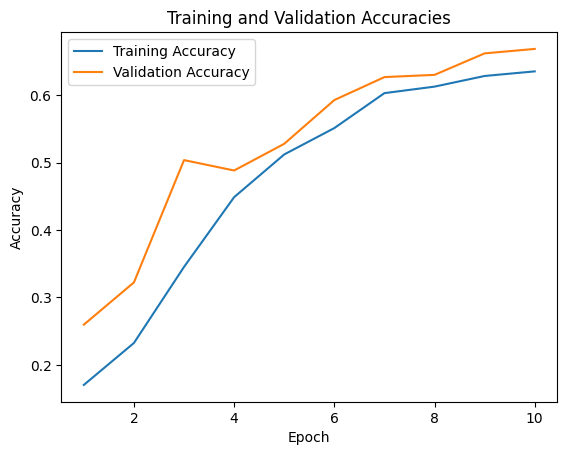

In [157]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

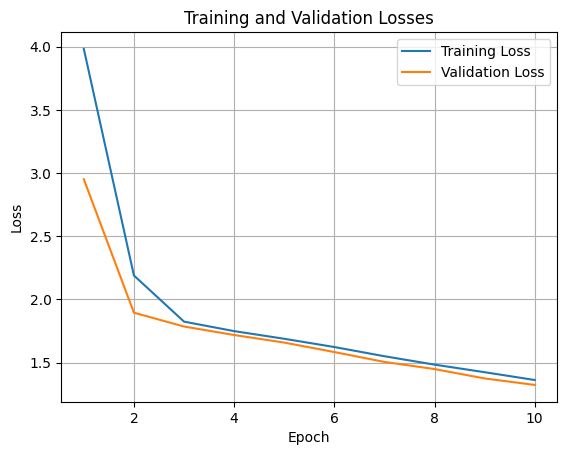

In [158]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

### 3.2 MobileNet V3

__Resize images to 224x224__

In [207]:
# Define the desired image size for MobileNetV3
new_image_size_mobilenet = 224  

# Define the transformation pipeline for MobileNetV3
transform_mobilenet = transforms.Compose([
    transforms.Resize((new_image_size_mobilenet, new_image_size_mobilenet)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Apply the transformation to your dataset
full_dataset_mobilenet = datasets.ImageFolder(root=data_dir, transform=transform_mobilenet)

# Create subsets for training, validation, and test sets using the sampled indices
train_set_mobilenet = Subset(full_dataset_mobilenet, train_indices)
val_set_mobilenet = Subset(full_dataset_mobilenet, val_indices)
test_set_mobilenet = Subset(full_dataset_mobilenet, test_indices)

# Define the batch size
batch_size = 20  
# Create DataLoader instances for the resized datasets for MobileNetV3
train_loader_mobilenet = DataLoader(train_set_mobilenet, batch_size=batch_size, shuffle=True)
val_loader_mobilenet = DataLoader(val_set_mobilenet, batch_size=batch_size, shuffle=False)
test_loader_mobilenet = DataLoader(test_set_mobilenet, batch_size=batch_size, shuffle=False)


__[1.] CNN Model Architecture__

In [214]:
# Load the pre-trained MobileNetV3 model
mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
# Freeze pre-trained layers
for param in mobilenet_v3.parameters():
    param.requires_grad = False
# Define the number of input features for the fully connected layer
num_ftrs = mobilenet_v3.classifier[-1].in_features

mobilenet_v3.classifier = nn.Sequential(
            nn.Linear(960, 512),  # First fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),       # Second fully connected layer
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)  # Final fully connected layer for predictions
        )
mobile_tuned_model = mobilenet_v3
# Print the tuned MobileNet V3 model
print(mobile_tuned_model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [215]:
criterion = nn.CrossEntropyLoss()
optimizer_mobile = optim.Adam(mobile_tuned_model.parameters(), lr=0.00001)

In [216]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer_mobile)
mobile_tuned_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

__[2.] Train and Evaluation of Model__

In [217]:
lr_scheduler = ReduceLROnPlateau(optimizer_mobile, mode='min', factor=0.1, patience=3, min_lr=1e-6)
custom_callback.set_model(mobile_tuned_model)

In [218]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    mobile_tuned_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader_mobilenet:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer_mobile.zero_grad()  # Zero the parameter gradients
        outputs = mobile_tuned_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer_mobile.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader_mobilenet.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    mobile_tuned_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in val_loader_mobilenet:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = mobile_tuned_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_loader_mobilenet.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 4.1602, Train Accuracy: 0.2053, Val Loss: 3.3404, Val Accuracy: 0.3542
Epoch [2/10], Train Loss: 2.4106, Train Accuracy: 0.3338, Val Loss: 1.8910, Val Accuracy: 0.4543
Epoch [3/10], Train Loss: 1.7584, Train Accuracy: 0.5233, Val Loss: 1.6569, Val Accuracy: 0.5490
Epoch [4/10], Train Loss: 1.5715, Train Accuracy: 0.5971, Val Loss: 1.4819, Val Accuracy: 0.6568
Epoch [5/10], Train Loss: 1.4215, Train Accuracy: 0.6429, Val Loss: 1.3433, Val Accuracy: 0.6854
Epoch [6/10], Train Loss: 1.2963, Train Accuracy: 0.6582, Val Loss: 1.2301, Val Accuracy: 0.6733
Epoch [7/10], Train Loss: 1.1956, Train Accuracy: 0.6796, Val Loss: 1.1389, Val Accuracy: 0.6931
Epoch [8/10], Train Loss: 1.1174, Train Accuracy: 0.6848, Val Loss: 1.0654, Val Accuracy: 0.7151
Epoch [9/10], Train Loss: 1.0486, Train Accuracy: 0.7049, Val Loss: 1.0048, Val Accuracy: 0.7184
Epoch [10/10], Train Loss: 1.0094, Train Accuracy: 0.7060, Val Loss: 0.9548, Val Accuracy: 0.7239


In [219]:
# Evaluation for test data
mobile_tuned_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader_mobilenet:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs =  mobile_tuned_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader_mobilenet.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.9561, Test Accuracy: 0.7327


__[3.] Analysing the results__

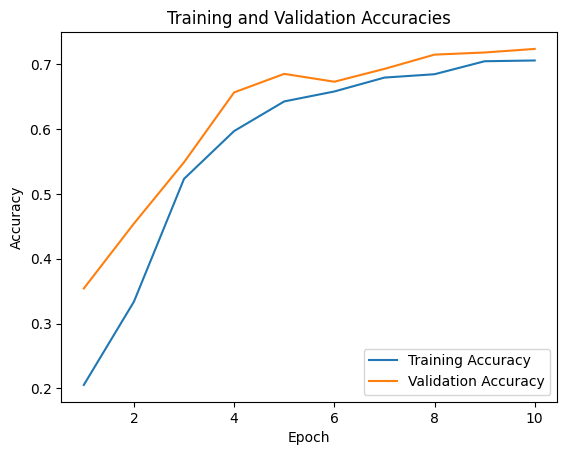

In [220]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

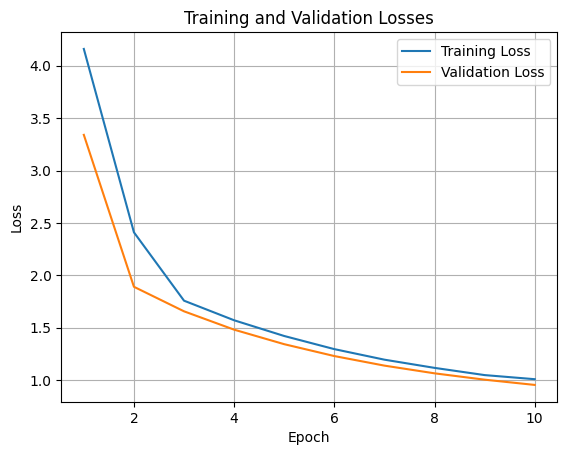

In [221]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

### 3.3 NasNet

We will resize the images into 331x331 pixels for NasNet.

In [196]:
# Define the desired image size for MobileNetV3
new_image_size_nasnet = 331  

# Define the transformation pipeline for MobileNetV3
transform_nasnet = transforms.Compose([
    transforms.Resize((new_image_size_nasnet, new_image_size_nasnet)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Apply the transformation to your dataset
full_dataset_nasnet = datasets.ImageFolder(root=data_dir, transform=transform_nasnet)

# Create subsets for training, validation, and test sets using the sampled indices
train_set_nasnet = Subset(full_dataset_nasnet, train_indices)
val_set_nasnet = Subset(full_dataset_nasnet, val_indices)
test_set_nasnet = Subset(full_dataset_nasnet, test_indices)

# Define the batch size
batch_size = 20  
# Create DataLoader instances for the resized datasets for MobileNetV3
train_loader_nasnet = DataLoader(train_set_nasnet, batch_size=batch_size, shuffle=True)
val_loader_nasnet = DataLoader(val_set_nasnet, batch_size=batch_size, shuffle=False)
test_loader_nasnet = DataLoader(test_set_nasnet, batch_size=batch_size, shuffle=False)


In [198]:
import pretrainedmodels
import torch
import torch.nn as nn

# Load pre-trained NASNet model
nasnet_model = pretrainedmodels.nasnetalarge(num_classes=1000, pretrained='imagenet')

# Freeze pre-trained layers
for param in nasnet_model.parameters():
    param.requires_grad = False

# Define the number of input features for the fully connected layer
num_ftrs = nasnet_model.last_linear.in_features

# Assuming 'inputs' is your input tensor with shape (batch_size, channels, height, width)
inputs = torch.randn(20, 3, 331, 331)  # Example input tensor

# Pass the inputs through the NASNet model to obtain feature maps
feature_maps = nasnet_model.features(inputs)

# Define the new classification head
classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # First fully connected layer
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),       # Second fully connected layer
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)  # Final fully connected layer for predictions
)

# Replace the classifier in the base model
nasnet_model.last_linear = classifier

# Assign the tuned model
nasnet_tuned_model = nasnet_model

# Print the tuned NASNet model
print(nasnet_tuned_model)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth" to /Users/thiradatiamklang/.cache/torch/hub/checkpoints/nasnetalarge-a1897284.pth
100%|██████████| 340M/340M [16:40<00:00, 356kB/s]    


NASNetALarge(
  (conv0): Sequential(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): Sequential(
      (relu): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (relu): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (separable_2): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(

In [199]:
print(nasnet_tuned_model)

NASNetALarge(
  (conv0): Sequential(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): Sequential(
      (relu): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (relu): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (separable_2): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(

In [200]:
criterion = nn.CrossEntropyLoss()
optimizer_nasnet = optim.Adam(nasnet_tuned_model.parameters(), lr=0.0001)

In [201]:
custom_callback = CustomCallback()
custom_callback.set_optimizer(optimizer_nasnet)
nasnet_tuned_model.to(device)

NASNetALarge(
  (conv0): Sequential(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): Sequential(
      (relu): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (relu): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (separable_2): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(

__[2.] Train and Evaluation of Model__

In [202]:
lr_scheduler = ReduceLROnPlateau(optimizer_nasnet, mode='min', factor=0.1, patience=3, min_lr=1e-6)
custom_callback.set_model(nasnet_tuned_model)

In [203]:
# Initialize lists to store epoch-wise values
train_losses = []  # List to store training losses
train_accuracies = []  # List to store training accuracies
val_losses = []  # List to store validation losses
val_accuracies = []  # List to store validation accuracies

# Training loop
num_epochs = 10  # Number of epochs for training
for epoch in range(num_epochs):
    # Training
    nasnet_tuned_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for inputs, labels in train_loader_nasnet:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer_nasnet.zero_grad()  # Zero the parameter gradients
        outputs = nasnet_tuned_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer_nasnet.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader_nasnet.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    nasnet_tuned_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in val_loader_nasnet:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = nasnet_tuned_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(val_loader_nasnet.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 1.8069, Train Accuracy: 0.4496, Val Loss: 1.0903, Val Accuracy: 0.6381
Epoch [2/10], Train Loss: 0.9152, Train Accuracy: 0.6931, Val Loss: 0.8195, Val Accuracy: 0.7349
Epoch [3/10], Train Loss: 0.7772, Train Accuracy: 0.7273, Val Loss: 0.7432, Val Accuracy: 0.7470
Epoch [4/10], Train Loss: 0.6912, Train Accuracy: 0.7511, Val Loss: 0.6897, Val Accuracy: 0.7536
Epoch [5/10], Train Loss: 0.6737, Train Accuracy: 0.7595, Val Loss: 0.7005, Val Accuracy: 0.7459
Epoch [6/10], Train Loss: 0.6272, Train Accuracy: 0.7756, Val Loss: 0.6434, Val Accuracy: 0.7569
Epoch [7/10], Train Loss: 0.6195, Train Accuracy: 0.7758, Val Loss: 0.6227, Val Accuracy: 0.7756
Epoch [8/10], Train Loss: 0.5970, Train Accuracy: 0.7852, Val Loss: 0.6670, Val Accuracy: 0.7646
Epoch [9/10], Train Loss: 0.5839, Train Accuracy: 0.7890, Val Loss: 0.6109, Val Accuracy: 0.7954
Epoch [10/10], Train Loss: 0.5488, Train Accuracy: 0.8074, Val Loss: 0.6396, Val Accuracy: 0.7800


In [204]:
# Evaluation for test data
nasnet_tuned_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader_nasnet:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs =  nasnet_tuned_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader_nasnet.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.6494, Test Accuracy: 0.7712


__[3.] Analysing result__

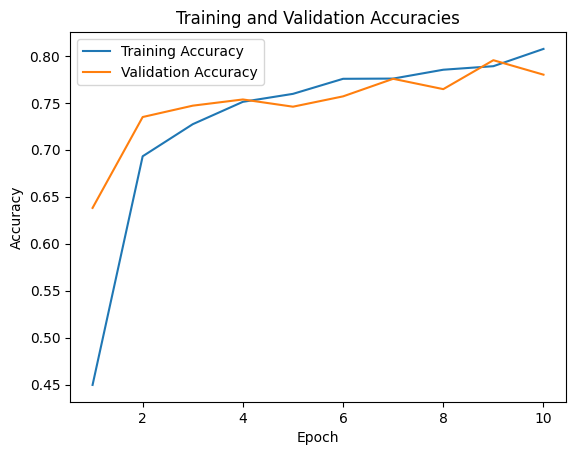

In [205]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

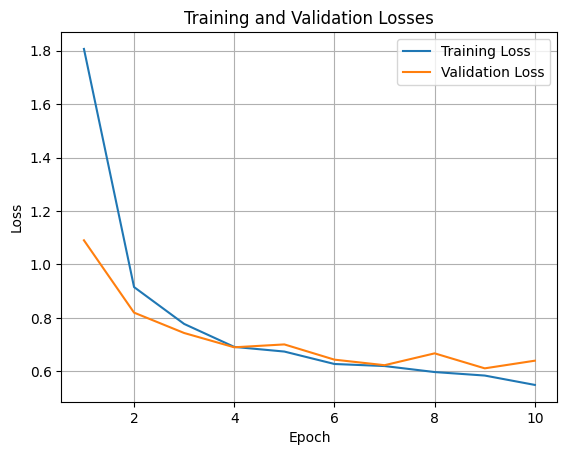

In [206]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot